In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

In [2]:
#load_data
with open('data_Mn-Cu-Cr-V-Fe-Ni-Co.pickle', 'rb') as f:
	data = pickle.load(f)

## Correct Erroneous Data

### Removing None Values

In [3]:
def remove_element_data(data):

	count = 0
	total = 0
	none_data = []
	for element, value in data.items():
		for mpid, spectrum in value.items():
			total += 1
			if spectrum['oxidation_state'] is None:
				count += 1
				none_data.append((element, mpid))

	for i in none_data:
		del data[i[0]][i[1]]

	return data

## Spectral Smoothing


In [4]:
# expanding the spectra 
def expand_spectra(intensity: np.array, energy: np.array, energy_grid: np.array) -> np.array:
    interval = energy[1] - energy[0]
    while energy[0] > energy_grid[0]:
        energy = np.insert(energy, 0, energy[0] - interval)
        intensity = np.insert(intensity, 0, 0)
    while energy[-1] < energy_grid[-1]:
        energy = np.insert(energy, len(energy), energy[-1] + interval)
        intensity = np.insert(intensity, len(intensity), 0)
    return intensity, energy

# smoothing the spectra
def savgol_smooth(intensity: np.array, energy: np.array, energy_grid: np.array, energy_window_length, polyorder: int = 3) -> np.array:
    intensity, energy = expand_spectra(intensity, energy, energy_grid)
    interval = energy[1] - energy[0]
    window_length = int(energy_window_length / interval)
    if window_length % 2 == 0:
        window_length += 1
    if window_length < polyorder + 2:
        window_length = polyorder + 2
    smooth_intensity = savgol_filter(intensity, window_length, polyorder)
    interp_func = interp1d(energy, smooth_intensity, kind='cubic')
    intensity_on_new_grid = interp_func(energy_grid)
    return intensity_on_new_grid


## Collate into a vector

In [ ]:
# print('Total number of spectra:', total)
# print('Number of spectra with unknown oxidation state:', count)

# jin_total = 0
# for element, value in data.items():
# 	for mpid, spectrum in value.items():
# 		jin_total += 1

# print('Number of spectra after removing unknown oxidation state:', jin_total)

# energy = data['Co']['mp-1001614']['energy']
# intensity = data['Co']['mp-1001614']['intensity']
# oxidation_state = data['Co']['mp-1001614']['oxidation_state']

# plt.plot(energy, intensity)
# print('oxidation state:', oxidation_state)

# # find the energy min and max
# energy_min = 800
# energy_max = 800

# for element, value in data.items():
# 	for mpid, spectrum in value.items():
# 		energy = spectrum['energy']
# 		if energy[0] < energy_min:
# 			energy_min = energy[0]
# 		if energy[-1] > energy_max:
# 			energy_max = energy[-1]

# print('energy_min:', energy_min)
# print('energy_max:', energy_max)

def get_intensity_vector(data, energy_window_length, energy_interval):
	'''
	Energy range is from 500 to 1020 eV
	'''
	energy_grid = np.arange(500, 1020, energy_interval)
	intensity_vector = []

	for element, value in data.items():
		for mpid, spectrum in value.items():
			energy = spectrum['energy']
			intensity = spectrum['intensity']
			intensity_on_new_grid = savgol_smooth(intensity, energy, energy_grid, energy_window_length)
			intensity_vector.append(intensity_on_new_grid)

	return np.array(intensity_vector)


def get_oxidation_vector(data):
	oxidation_states = [sorted(i['oxidation_state']) for element in data.values() for i in element.values()]
	oxidation_state_processed = np.zeros((len(oxidation_states), 8))
	
	for idx, state in enumerate(oxidation_states):
			counter = Counter(state)
			for key, value in counter.items():
				oxidation_state_processed[idx, key] = value
	
	oxidation_state_processed_sum = np.sum(oxidation_state_processed, axis=1).reshape(-1, 1)
	oxidation_state_processed = oxidation_state_processed*1/oxidation_state_processed_sum

	return oxidation_state_processed


(5848, 5200) (5848, 8)


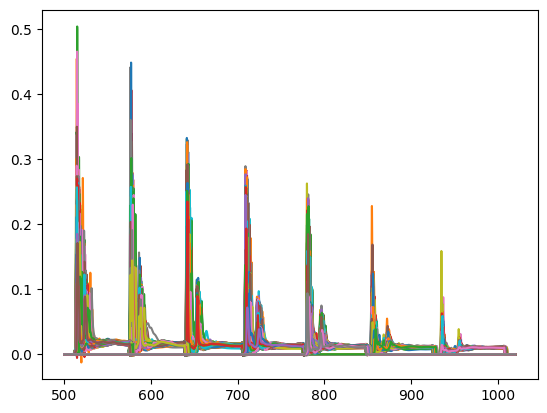

In [8]:
energy_window_length = 1.5 # in eV
energy_interval = 0.1 # in eV
intensity_use = get_intensity_vector(data, energy_window_length, energy_interval)
oxidation_state_use = get_oxidation_vector(data)

for i in intensity_use:
    plt.plot(np.arange(500, 1020, 0.1), i)

print(intensity_use.shape, oxidation_state_use.shape)

In [10]:
X = np.array(intensity_use)
Y = np.array(oxidation_state_use)

X.shape, Y.shape

((5848, 5200), (5848, 8))

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # if you use same random state, same sets will be created
# 80-20% train test split

print("training size: ", x_train.shape, y_train.shape)
print("testing size: ", x_test.shape, y_test.shape)

training size:  (4678, 5200) (4678, 8)
testing size:  (1170, 5200) (1170, 8)


In [12]:
# save the data into numpy files

np.save("../dataset/x_train.npy", x_train)
np.save("../dataset/y_train.npy", y_train)
np.save("../dataset/x_test.npy", x_test)
np.save("../dataset/y_test.npy", y_test)

#can be loaded like so
x_train = np.load("../dataset/x_train.npy")
x_train.shape

(4678, 5200)

## Plot i/o statistics

5848


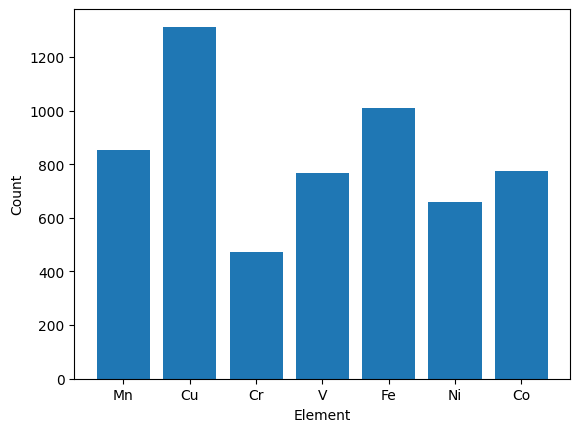

In [18]:
elements = list(data.keys())
counts = list(map(lambda x: len(x), data.values()))
print(sum(counts))
plt.bar(elements, counts)
plt.xlabel('Element')
plt.ylabel('Count')

plt.show()

In [30]:
oxidation_states = [sorted(i['oxidation_state']) for element in data.values() for i in element.values()]

oxidation_state_processed = np.zeros((len(oxidation_states), 8))

for idx, state in enumerate(oxidation_states):
	counter = Counter(state)
	for key, value in counter.items():
		oxidation_state_processed[idx, key] = value

In [37]:
oxidation_state_processed_sum = np.sum(oxidation_state_processed, axis=1).reshape(-1, 1)
oxidation_state_processed = oxidation_state_processed*1/oxidation_state_processed_sum

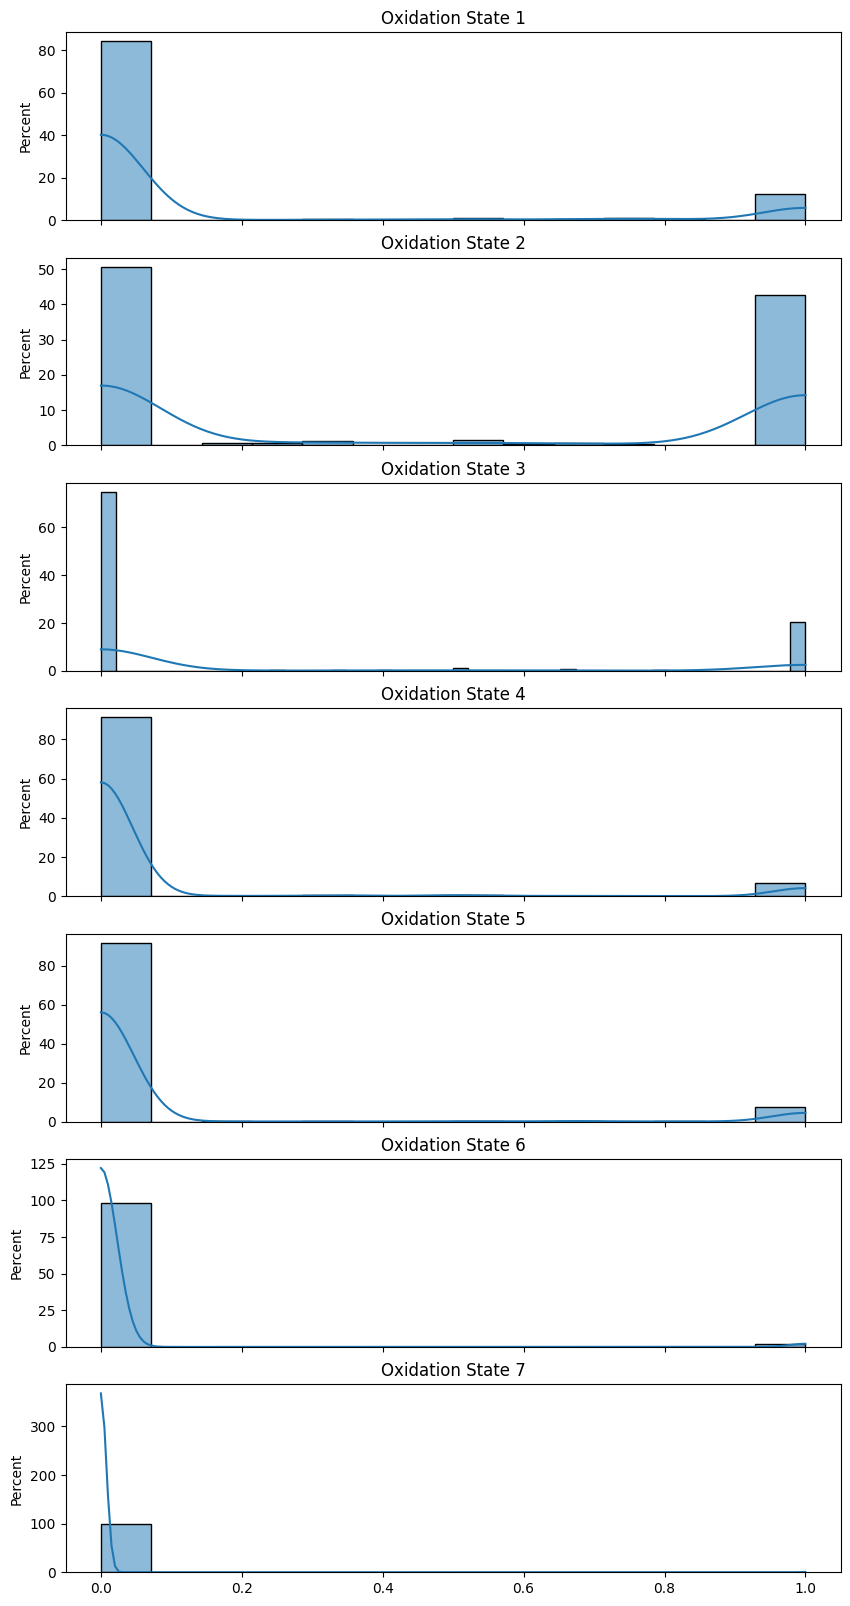

In [54]:
fig, ax = plt.subplots(7, 1, sharex=True, figsize=(10, 20))

for i in range(7):
	j = i+1
	sns.histplot(oxidation_state_processed[:, j], stat = 'percent', ax = ax[i],
				 kde=True)
	ax[i].set_title(f'Oxidation State {j}')

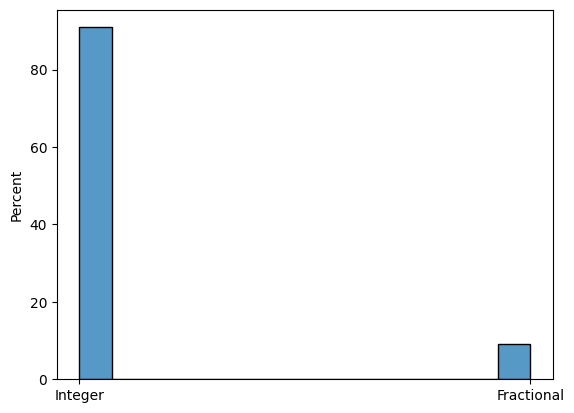

In [62]:
integer_states = oxidation_state_processed != 0
integer_states = np.sum(integer_states, axis = 1)
sns.histplot(integer_states, stat = 'percent')
plt.xticks([1.0, 2.0], ['Integer', 'Fractional'])
plt.show()